### Импорт библиотек

In [ ]:
#import nltk
#from nltk.stem import WordNetLemmatizer
#from nltk.tokenize import word_tokenize
#from nltk import pos_tag
#from sklearn.decomposition import LatentDirichletAllocation
#from operator import itemgetter
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score, classification_report
#from sklearn.metrics.pairwise import cosine_similarity
#from sklearn.feature_extraction.text import TfidfVectorizer
#!pip install pymorphy3 # Морфологический анализ
#from pymorphy3 import MorphAnalyzer
#from collections import Counter
#!python -m spacy download ru_core_news_md
#nltk.download("stopwords")

In [19]:
!pip install telethon==1.34
!pip install pyTelegramBotAPI==4.21
from telethon import TelegramClient
from telebot import TeleBot, types, async_telebot
import asyncio
import nest_asyncio
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from transformers import pipeline
import matplotlib.pyplot as plt
nest_asyncio.apply()

### Авторизация

In [13]:
api_id = "29102172"
api_hash = "19936a01beb14acfaebb7e45f6a72b40"
bot_tok = "7126662921:AAEUpXS1LfkTMvRok5S7Tua-2Zf6sx8f8GQ"
client = TelegramClient("test", api_id, api_hash) # Здесь 'test' — это название файла, который будет создан для хранения авторизационных данных приложения
client.connect()

<coroutine object TelegramBaseClient.connect at 0x7e6f9237a030>

### Создание функций для парсинга

#### Посты

In [14]:
async def get_tg_channel(username, limit=None, get_users=False):
    username = await client.get_entity(username)
    messages = client.iter_messages(username, limit=limit)

    async for message in messages:
        if message.text != None and len(message.text) > 1:
            post_id.append(message.id)
            post_text.append(message.text.replace("\n", " ").replace("  ", " "))
            post_dates.append(message.date)
            post_views.append(message.views)

            try:
                post_comments.append(message.replies.replies)
            except:
                post_comments.append(0)

            try:
                count_reac = []
                reac_types = []
                for reac in message.reactions.results:
                    try:
                        count_reac.append(reac.count)
                        reac_types.append(reac.reaction.emoticon)
                    except:
                        continue

                post_likes.append(sum(count_reac))
                post_emotion_types.append(reac_types)

            except:
                post_likes.append(0)
                post_emotion_types.append("-")

            #sender = await message.get_sender()
            #senders.append(sender.id)

    if get_users == True:
        users = client.iter_participants(username)
        async for user in users:
            users_list.append(user.username)


def make_dataframe_posts(calculate_inf=True):
    response_1 = np.array(post_likes)/np.array(post_views)
    response_2 = np.array(post_comments)/np.array(post_views)

    data = list(zip(post_id, post_dates, post_text, post_views, post_likes,
                    post_emotion_types, post_comments, response_1, response_2))

    df = pd.DataFrame(data, columns = ["ID", "Date", "Text", "Views_Count", "Reaction_Count", "Emotion_Types",
                                       "Comments_Count", "Response_1", "Response_2"])

    if calculate_inf==False:
        return df.set_index("Date")

    else:
        clf_emotion = pipeline(task='sentiment-analysis', model='cointegrated/rubert-tiny2-cedr-emotion-detection', top_k=None)
        clf_toxicicity = pipeline(task='sentiment-analysis', model='khvatov/ru_toxicity_detector', top_k=None)
        clf_tonality = pipeline(task='sentiment-analysis', model='seara/rubert-tiny2-russian-sentiment', top_k=None)

        prior_emotion = []
        toxicity = []
        neutral = []
        negative = []
        positive = []

        for t in tqdm(df["Text"]):
            emotion_analyse = clf_emotion(t)
            tox_analyse = clf_toxicicity(t)
            ton_analyse = clf_tonality(t)
            prior_emotion.append(emotion_analyse[0][0]["label"])
            if tox_analyse[0][0]["label"] == "LABEL_0":
                toxicity.append("non toxic")
            else:
                toxicity.append("toxic")

            for row_ton in ton_analyse[0]:
                if row_ton['label'].lower() == 'neutral':
                    neutral.append(row_ton['score'])
                elif row_ton['label'].lower() == 'negative':
                    negative.append(row_ton['score'])
                elif row_ton['label'].lower() == 'positive':
                    positive.append(row_ton['score'])

        calculated_inf = pd.DataFrame(list(zip(prior_emotion, toxicity, neutral, negative, positive)),
                                      columns=["Prior Emotion", "Toxicity", "Neutral", "Negative", "Positive"])

        return df.join(calculated_inf).set_index("Date")

In [5]:
post_id = []
post_dates = []
post_text = []
post_likes = []
post_emotion_types = []
post_views = []
post_comments = []
senders = []
users_list = []

async with client:
    client.loop.run_until_complete(get_tg_channel(-1001815927648, limit=250))

df = make_dataframe_posts()
df

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


  0%|          | 0/187 [00:00<?, ?it/s]

,ID,Text,Views_Count,Reaction_Count,Emotion_Types,Comments_Count,Response_1,Response_2,Prior Emotion,Toxicity,Neutral,Negative,Positive
Date,,,,,,,,,,,,,
2024-07-03 13:47:43+00:00,1524,=БАЛБЕСЫ=,103,29,"[🤯, ❤, ⚡, ✍, 🔥, 💯]",30,0.281553,0.291262,anger,toxic,0.305983,0.030539,0.663478
2024-07-01 08:07:24+00:00,1523,"все, уволился я армия остаётся, король отступает",119,27,"[😢, ❤, 🎉, ✍]",8,0.226891,0.067227,no_emotion,non toxic,0.328837,0.649702,0.021462
2024-06-27 10:00:01+00:00,1522,"кароче никто не угадал, там просто ремонт но п...",172,14,"[💩, 💯]",4,0.081395,0.023256,no_emotion,non toxic,0.605952,0.357759,0.036290
2024-06-27 09:42:09+00:00,1521,"кто угадает, зачем нужно столько знаков, получ...",157,16,"[🤨, ❤]",13,0.101911,0.082803,no_emotion,non toxic,0.785510,0.065799,0.148690
2024-06-26 04:01:30+00:00,1520,однажды в приложении РЖД начнут писать путь по...,141,18,"[⚡, ❤, 💩]",4,0.127660,0.028369,no_emotion,non toxic,0.864721,0.073380,0.061899
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-10 10:41:22+00:00,1284,"друзья, внимание тяжёлый люкс, лютейший флекс....",155,22,"[🔥, 🤯, ⚡, ❤, 💯]",4,0.141935,0.025806,fear,non toxic,0.481849,0.069706,0.448445
2024-02-10 10:17:48+00:00,1283,"как выбрасывать старые игрушки, помогите рука ...",142,16,"[😢, 🤯, 👎]",21,0.112676,0.147887,no_emotion,non toxic,0.611352,0.380366,0.008282
2024-02-09 09:31:52+00:00,1282,"иногда хочется, чтобы у всех в головах играла ...",181,22,"[❤, ⚡]",11,0.121547,0.060773,joy,non toxic,0.206805,0.026817,0.766378


#### Комментарии и комментаторы

In [15]:
async def get_tg_comments(username, limit=None):
    username = await client.get_entity(username)
    messages = client.iter_messages(username, limit=limit)

    async for message in messages:
        try:
            async for reply in client.iter_messages(username, reply_to=message.id):
                if len(reply.message) > 1:
                    try:
                        id.append(reply.from_id.user_id)
                        us = await client.get_entity(reply.from_id.user_id)
                        FI.append(" ".join([str(us.first_name), str(us.last_name)]).replace("None", "-"))
                        user_name.append(str(us.username).replace("None", "-"))
                    except:
                        id.append(reply.from_id.channel_id)
                        us = await client.get_entity(reply.from_id.channel_id)
                        FI.append("Admin")
                        user_name.append(str(us.title))
                    comments_text.append(reply.message.replace("\n", " ").replace("  ", " "))

        except:
            continue


def make_dataframe_comments(calculate_inf=True):
    data = list(zip(id, FI, user_name, comments_text))
    df_comments = pd.DataFrame(data, columns = ["ID", "FI", "Username", "Comment"])

    if calculate_inf == False:
        return pd.DataFrame(data, columns = ["ID", "FI", "Username", "Comment"])

    else:
        clf_emotion = pipeline(task='sentiment-analysis', model='cointegrated/rubert-tiny2-cedr-emotion-detection', top_k=None)
        clf_toxicicity = pipeline(task='sentiment-analysis', model='khvatov/ru_toxicity_detector', top_k=None)
        clf_tonality = pipeline(task='sentiment-analysis', model='seara/rubert-tiny2-russian-sentiment', top_k=None)

        prior_emotion = []
        toxicity = []
        neutral_comm = []
        negative_comm = []
        positive_comm = []

        for comm in tqdm(df_comments["Comment"]):
            emotion_analyse = clf_emotion(comm)
            tox_analyse = clf_toxicicity(comm)
            ton_analyse = clf_tonality(comm)
            prior_emotion.append(emotion_analyse[0][0]["label"])
            if tox_analyse[0][0]["label"] == "LABEL_0":
                toxicity.append("non toxic")
            else:
                toxicity.append("toxic")

            for row_ton in ton_analyse[0]:
                if row_ton['label'].lower() == 'neutral':
                    neutral_comm.append(row_ton['score'])
                elif row_ton['label'].lower() == 'negative':
                    negative_comm.append(row_ton['score'])
                elif row_ton['label'].lower() == 'positive':
                    positive_comm.append(row_ton['score'])

        calculated_inf = pd.DataFrame(list(zip(prior_emotion, toxicity, neutral_comm, negative_comm, positive_comm)),
                                      columns=["Prior Emotion", "Toxicity", "Neutral", "Negative", "Positive"])

        return df_comments.join(calculated_inf)

In [7]:
id = []
FI = []
user_name = []
comments_text = []

async with client:
    client.loop.run_until_complete(get_tg_comments(-1001815927648, limit=20))

df_comments = make_dataframe_comments()
df_comments

  0%|          | 0/127 [00:00<?, ?it/s]

,ID,FI,Username,Comment,Prior Emotion,Toxicity,Neutral,Negative,Positive
0,1935727412,Даниил Енотик ☭,Neprav_enot,АААААААААААААААААААААААААААААААААААААААААААААА...,joy,toxic,0.031321,0.025217,0.943463
1,1872725692,0/5 ult enjoyer,ZZZeri_enjoyer_questionmark,Постов нет уже 11 дней,no_emotion,non toxic,0.766654,0.205688,0.027658
2,327856070,Ильдар! -,iamabo,Смешняковские Поздравления!!!,joy,non toxic,0.051898,0.004630,0.943472
3,413125921,Вадим -,savvadim,"пацанам по 30 лет, слева малой",sadness,non toxic,0.818128,0.084536,0.097336
4,404112309,викс -,introvix,yes thats my bestie,anger,non toxic,0.099897,0.036388,0.863715
...,...,...,...,...,...,...,...,...,...
122,5292371351,Ьогдан -,Yfvntds,Ураааа! Теперь Тоша круче чем был,anger,toxic,0.007025,0.002028,0.990947
123,245914616,георгий сажин,ya_opazdivau,мужик,no_emotion,non toxic,0.659087,0.291325,0.049588
124,714880670,Деньчьк -,ZhaaBaalove,Нахуя,anger,toxic,0.329662,0.351458,0.318880
125,714880670,Деньчьк -,ZhaaBaalove,Урааа,joy,non toxic,0.010438,0.003319,0.986242


### Статистика по собранным данным

In [16]:
# distribution of views
def views_distribution(df):
    plt.style.use("bmh")
    plt.figure(figsize=(10, 5), constrained_layout=True)
    plt.bar(df.index, df["Views_Count"], color="#6C92AF")
    plt.title("Distribution of views", fontsize=16)
    plt.gca().set_axisbelow(True)
    plt.savefig("Views_distribution.png")

# Toxicity and emotions
def toxic_and_emotion_stat(df, object):
    plt.style.use("bmh")
    fig, axs = plt.subplots(3, figsize=(6, 6), constrained_layout=True)
    axs[0].bar(df["Toxicity"].value_counts().index, df["Toxicity"].value_counts(), color="teal", width=0.3)
    axs[0].set_title(f"Toxicity of {object}", fontsize=13)
    axs[0].set_ylabel("Frequency")
    axs[0].set_axisbelow(True)
    axs[1].bar(df["Prior Emotion"].value_counts().index, df["Prior Emotion"].value_counts(), color="palevioletred")
    axs[1].set_title(f"Emotions of {object}", fontsize=13)
    axs[1].set_ylabel("Frequency")
    axs[1].set_axisbelow(True)
    axs[2].bar(df[["Neutral", "Negative", "Positive"]].mean().index, df[["Neutral", "Negative", "Positive"]].mean(),
        color="#2A6478", width=0.4)
    axs[2].set_title(f"Tonality of {object}", fontsize=13)
    axs[2].set_ylabel("Mean Coefficient")
    axs[2].set_axisbelow(True)
    plt.savefig("Result.png")

# Most active commentators
def top_commentators(data, how_many=15):
    top_comm = data["Username"].value_counts()[0:how_many]
    plt.style.use("bmh")
    plt.figure(figsize=(12, 6), constrained_layout=True)
    plt.bar(top_comm.index, top_comm, color="goldenrod")
    plt.xticks(rotation=55, fontsize=11)
    plt.yticks(fontsize=11)
    plt.ylabel("Number of Comments")
    plt.title("Most active commentators", fontsize=16)
    plt.gca().set_axisbelow(True)
    plt.savefig("Top_commentators.png")

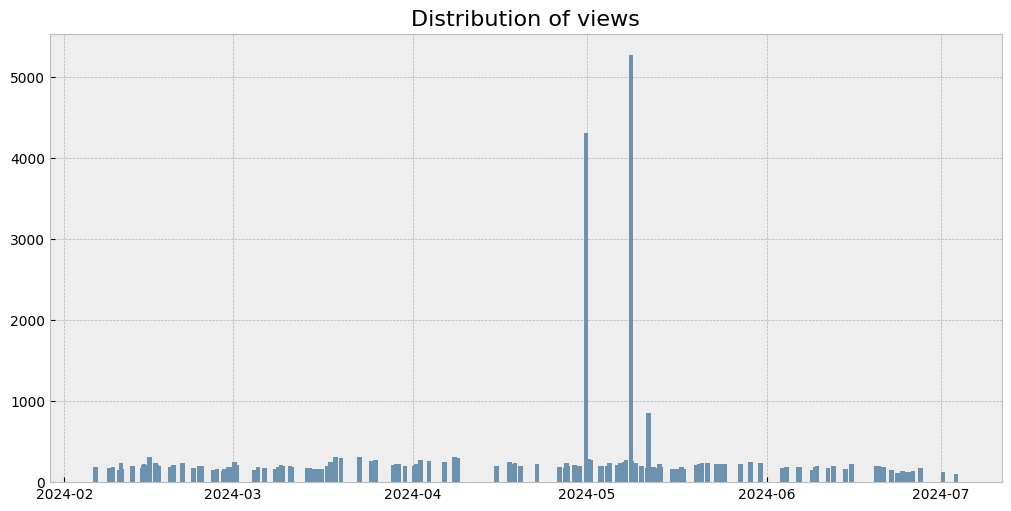

In [9]:
views_distribution(df)

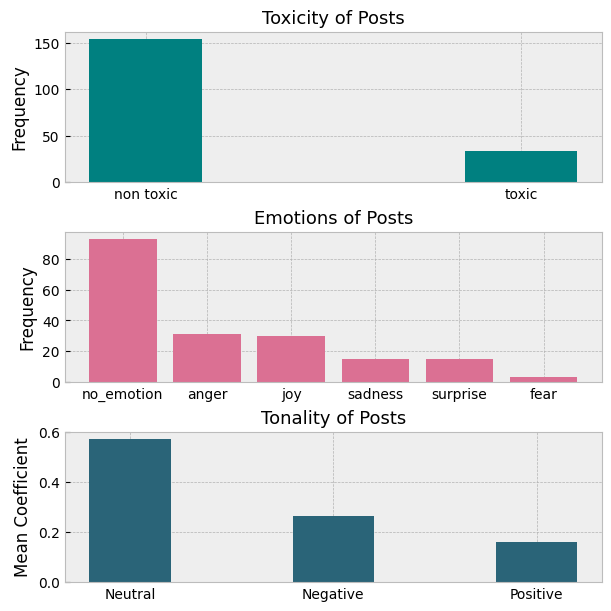

In [10]:
toxic_and_emotion_stat(df, "Posts")

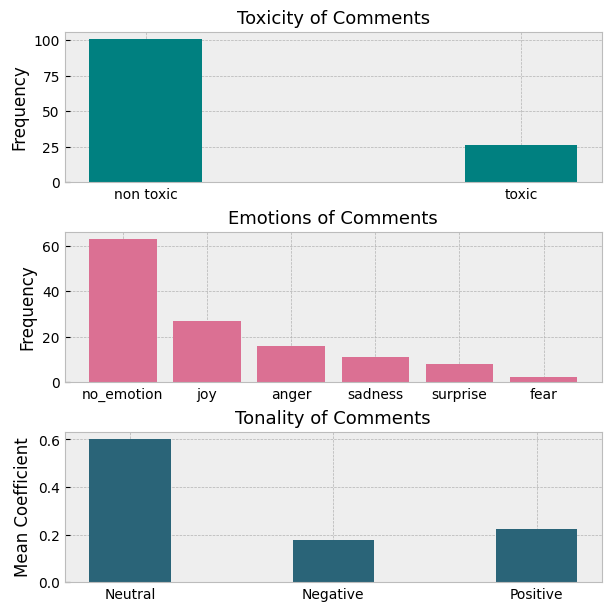

In [11]:
toxic_and_emotion_stat(df_comments, "Comments")

In [14]:
filtered_commentators = df_comments[df_comments["Username"].isin(df_comments["Username"].value_counts()[0:15].index)]

In [15]:
filtered_commentators.groupby("Username")[["Neutral", "Negative", "Positive"]].agg(['sum', 'mean'])

Neutral            Negative            Positive  \
                          sum      mean       sum      mean       sum   
Username                                                                
AHekDoT_npo_eBpeeB  10.095826  0.531359  4.485104  0.236058  4.419070   
C0ld_man             1.383874  0.691937  0.539003  0.269501  0.077123   
Neprav_enot          1.694389  0.423597  0.164481  0.041120  2.141130   
VITYABLOCKBASTER     1.360680  0.453560  0.780559  0.260186  0.858761   
Yfvntds              5.175974  0.575108  1.226595  0.136288  2.597431   
ZhaaBaalove          0.340100  0.170050  0.354777  0.177389  1.305123   
alloprivetdenchik    2.267037  0.566759  1.508925  0.377231  0.224038   
apk_lover           18.730536  0.645881  5.078908  0.175135  5.190556   
artyom_rogalik       1.364251  0.682126  0.549365  0.274683  0.086384   
dogma_ex            13.690146  0.720534  2.242352  0.118019  3.067502   
firacit              2.731848  0.546370  1.227924  0.245585  1.040228   
introvix             6.691231  0.608294  1.022179  0.092925  3.286590   
savvadim             3.081600  0.616320  0.973303  0.194661  0.945097   
syeIeda              1.721031  0.573677  0.225366  0.075122  1.053603   
ya_opazdivau         1.529875  0.764937  0.405226  0.202613  0.064899   

                              
                        mean  
Username                      
AHekDoT_npo_eBpeeB  0.232583  
C0ld_man            0.038562  
Neprav_enot         0.535283  
VITYABLOCKBASTER    0.286254  
Yfvntds             0.288603  
ZhaaBaalove         0.652561  
alloprivetdenchik   0.056010  
apk_lover           0.178985  
artyom_rogalik      0.043192  
dogma_ex            0.161447  
firacit             0.208046  
introvix            0.298781  
savvadim            0.189019  
syeIeda             0.351201  
ya_opazdivau        0.032450

In [ ]:
pd.DataFrame(filtered_commentators.groupby("Username")["Prior Emotion"].value_counts())

count
Username           Prior Emotion       
AHekDoT_npo_eBpeeB no_emotion        13
                   joy                3
                   anger              3
C0ld_man           anger              1
                   sadness            1
Neprav_enot        no_emotion         2
                   anger              1
                   joy                1
VITYABLOCKBASTER   anger              1
                   no_emotion         1
                   sadness            1
Yfvntds            no_emotion         3
                   anger              2
                   joy                2
                   sadness            1
                   surprise           1
ZhaaBaalove        joy                1
                   anger              1
alloprivetdenchik  no_emotion         3
                   sadness            1
apk_lover          no_emotion        12
                   joy                8
                   sadness            4
                   surprise           3
                   anger              2
artyom_rogalik     surprise           1
                   sadness            1
dogma_ex           no_emotion        14
                   joy                5
firacit            no_emotion         3
                   joy                1
                   anger              1
introvix           joy                4
                   no_emotion         3
                   anger              2
                   surprise           1
                   fear               1
savvadim           no_emotion         2
                   sadness            2
                   surprise           1
syeIeda            anger              1
                   joy                1
                   surprise           1
ya_opazdivau       no_emotion         2

In [ ]:
pd.DataFrame(filtered_commentators.groupby("Username")["Toxicity"].value_counts())

count
Username           Toxicity        
AHekDoT_npo_eBpeeB non toxic     13
                   toxic          6
C0ld_man           toxic          2
Neprav_enot        non toxic      2
                   toxic          2
VITYABLOCKBASTER   non toxic      3
Yfvntds            non toxic      5
                   toxic          4
ZhaaBaalove        toxic          1
                   non toxic      1
alloprivetdenchik  toxic          2
                   non toxic      2
apk_lover          non toxic     28
                   toxic          1
artyom_rogalik     toxic          1
                   non toxic      1
dogma_ex           non toxic     16
                   toxic          3
firacit            non toxic      5
introvix           non toxic      8
                   toxic          3
savvadim           non toxic      5
syeIeda            non toxic      3
ya_opazdivau       non toxic      2

#### Взаимодействие с ботом

In [ ]:
bot = async_telebot.AsyncTeleBot('7126662921:AAEUpXS1LfkTMvRok5S7Tua-2Zf6sx8f8GQ')

# commands
post_info = "group_posts"
comments_info = "group_comments"
comand = []

@bot.message_handler(commands=['start'])
async def handle_start(message):
    # Отправка сообщения: приветствие
    markup = types.ReplyKeyboardMarkup(resize_keyboard=True)
    item1 = types.KeyboardButton("/" + post_info)
    item2 = types.KeyboardButton("/" + comments_info)
    markup.add(item1, item2)

    if message.from_user.username:
        await bot.send_message(message.chat.id,
                               f'Здравствуй, {message.from_user.username}! Я могу спарсить телеграм канал и сделать некоторую статистическую сводку по постам и комментариям данного канала. Чтобы начать посмотри меню основных команд или нажми одну из кнопок внизу.', reply_markup=markup)

    else:
        await bot.send_message(message.chat.id,
                               f'Здравствуй, {message.from_user.first_name}! Я могу спарсить телеграм канал и сделать некоторую статистическую сводку по постам и комментариям данного канала. Чтобы начать посмотри меню основных команд или нажми одну из кнопок внизу.', reply_markup=markup)

@bot.message_handler(commands=[post_info, comments_info])
async def handle_message(message):
    await bot.reply_to(message, 'Введи id или username группы, по которой хочешь получить информацию')
    comand.append(message.text)

post_id = []
post_dates = []
post_text = []
post_likes = []
post_emotion_types = []
post_views = []
post_comments = []

id = []
FI = []
user_name = []
comments_text = []

@bot.message_handler(func=lambda message:True)
async def handle_message(message):
    global response

    try:
        response = int(message.text)
    except:
        response = message.text

    if comand[-1] == ("/" + post_info):

        try:
            await bot.send_message(message.chat.id, 'Потребуется немного времени, чтобы собрать все посты в группе...')

            async with client:
                client.loop.run_until_complete(get_tg_channel(response, limit=None))

            df_bot = make_dataframe_posts()
            df_bot.to_html("Data_with_posts.html")
            views_distribution(df_bot)
            toxic_and_emotion_stat(df_bot, "Posts")

            await bot.send_document(message.chat.id, document=open("Data_with_posts.html", "rb"))
            await bot.send_photo(message.chat.id, photo=open("Views_distribution.png", "rb"))
            await bot.send_photo(message.chat.id, photo=open("Result.png", "rb"))

        except:
            await bot.send_message(message.chat.id, 'Перепроверь свой запрос, я не могу его обработать')

        post_id.clear()
        post_dates.clear()
        post_text.clear()
        post_likes.clear()
        post_emotion_types.clear()
        post_views.clear()
        post_comments.clear()
        comand.append(0)

    elif comand[-1] == ("/" + comments_info):

        try:
            await bot.send_message(message.chat.id, 'Придётся немного подождать, идёт сбор комментариев...')

            async with client:
                client.loop.run_until_complete(get_tg_comments(response, limit=30))

            global df_comments_bot
            df_comments_bot = make_dataframe_comments()
            df_comments_bot.to_html("Data_with_comments.html")
            toxic_and_emotion_stat(df_comments_bot, "Comments")
            top_commentators(df_comments_bot)

            await bot.send_document(message.chat.id, document=open("Data_with_comments.html", "rb"))
            await bot.send_photo(message.chat.id, photo=open("Result.png", "rb"))
            await bot.send_photo(message.chat.id, photo=open("Top_commentators.png", "rb"))
            await bot.send_message(message.chat.id, '''Если тебя интересуют конкретные пользователи (пользователь), ты можешь прислать мне их username.
                                                    Я предоставлю сводку по комментариям этих пользовотелей в данной группе.''')

        except:
            await bot.send_message(message.chat.id, 'Перепроверь свой запрос, я не могу его обработать')

        id.clear()
        FI.clear()
        user_name.clear()
        comments_text.clear()
        comand.append(0)

    elif set(response.split(sep=", ")).issubset(df_comments_bot["Username"].unique()):
        wanted_users = set(response.split(sep=", ")).intersection(set(df_comments_bot["Username"].unique()))
        filter_df_comments = df_comments_bot[df_comments_bot["Username"].isin(wanted_users)]
        tonality_of_spec_users = filter_df_comments.groupby("Username")[["Neutral", "Negative", "Positive"]].agg(['sum', 'mean'])
        emotion_of_spec_users = pd.DataFrame(filter_df_comments.groupby("Username")["Prior Emotion"].value_counts())
        toxic_of_spec_users = pd.DataFrame(filter_df_comments.groupby("Username")["Toxicity"].value_counts())

        filter_df_comments.to_html("Data_with_spec_users_comments.html")
        tonality_of_spec_users.to_html("Tonality_spec_users_comments.html")
        emotion_of_spec_users.to_html("Emotion_spec_users_comments.html")
        toxic_of_spec_users.to_html("Toxic_spec_users_comments.html")

        await bot.send_document(message.chat.id, document=open("Data_with_spec_users_comments.html", "rb"))
        await bot.send_document(message.chat.id, document=open("Tonality_spec_users_comments.html", "rb"))
        await bot.send_document(message.chat.id, document=open("Emotion_spec_users_comments.html", "rb"))
        await bot.send_document(message.chat.id, document=open("Toxic_spec_users_comments.html", "rb"))

    else:
        await bot.send_message(message.chat.id, 'Перепроверь свой запрос, я не могу его обработать')


asyncio.run(bot.polling(none_stop=True))

In [ ]:
set(response.split(sep=", ")).issubset(df_comments_bot["Username"].unique())

### Тематический Анализ и Нормализация Текста

In [ ]:
# Нормализация текста и мешок слов
"""
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
"""
#stop_words_spacy = list(spacy.load('ru_core_news_md').Defaults.stop_words)
stop_words_nltk = nltk.corpus.stopwords.words('russian')
#russian_stop_words = list((set(stop_words_spacy + stop_words_nltk)))

pos_tags = ["NOUN", "ADJF", "COMP", "ADJS", "VERB", "INFN", "PRTF", "PRTS", "ADVB"] # Список с частями речи     # ["JJ", "JJR", "JJS", "MD", "NN", "NNS", "NNPS", "PDT", "PRP", "PRP$", "RB", "RBR", "RBS", "RP", "VB", "VBG", "VBD", "VBN", "WP"]
morph = MorphAnalyzer()
tokenized_post = []
lemmatized_posts = []

for post in tqdm(list(df["Text"])):
  try:
    tokenized_post.append(nltk.word_tokenize(post))
  except:
    continue

for tok_post in tqdm(tokenized_post):
  text_tokens = []
  for token in tok_post:
    token_morph = morph.parse(token)[0] # [0] - Самое вероятное описание слова
    if token_morph.tag.POS in pos_tags and token_morph.normal_form not in stop_words_nltk and token not in stop_words_nltk:
      text_tokens.append(token_morph.normal_form)
  lemmatized_posts.append(text_tokens)

  0%|          | 0/1032 [00:00<?, ?it/s]

In [ ]:
j_bag = []
tokens = []
for qu in lemmatized_posts:
    j_bag.append(" ".join(qu))

for l in tqdm(lemmatized_posts):
    for word in l:
        tokens.append(word)

pd.DataFrame(dict(Counter(tokens)).items()).sort_values(by=1, ascending=False).reset_index(drop=True)

  0%|          | 0/1032 [00:00<?, ?it/s]

,0,1
20,тип,37
21,сегодня,37
22,сказать,36
23,год,36
24,время,35
25,че,34
26,канал,34
27,ваш,33
28,какой-то,33
29,рисовать,33


In [ ]:
j_bag

['мужик отправить остальной давать-давать работать тачил заценить дядька нужный',
 'отправлять весь мужик оценить',
 'мужик оценить',
 'цветок женщина баловать свой мужчина',
 'придурок рот открыть спасиб лина принтер смешной фотокарточка когда-нибудь перестать путать отложка канал пока терпимый',
 'ржак недавний всеобщий негодование админус повод завысить охват всякий блогер полный отсутствие просмотр буквально остальной пабликовый администрация принять решение вырубить возможность смотреть просмотр пабликовый претендовать популярность супер высокий охват смотреть челик замечать пукно какно синга война делиться часто отвлекаться маленький циферка угол экран',
 'пара год назад цена слетать туда дата втроём',
 'работа лайкать пора',
 '',
 'ладный лайкать',
 'порепостит куда-нибудь свой огромный ржак получиться подумать хахер лайковый хотеть подписчик миллард мильонв парочка',
 'орудие пропаганда зарядить',
 '',
 'знать',
 'отодвинуть шкаф найти первый нереальный рисунок карандаш остатьс

In [ ]:
# Кластеризация тематик группы
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1, 1))
x = tfidf.fit_transform(j_bag).toarray()
cluster_num = 19
lda = LatentDirichletAllocation(n_components=cluster_num,  # кол-во кластеров
                                learning_method="batch",  # batch математически более эффективен
                                max_iter=300,  # обычно 100
                                random_state=0)

document_topics = lda.fit_transform(x)

sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
feature_names = np.array(list(dict(sorted(tfidf.vocabulary_.items(), key=itemgetter(1))).keys()))
clusters_tokens = []
for num in tqdm(range(0, cluster_num)):
    tokens_list = list(feature_names[list(sorting[num])])
    clusters_tokens.append(tokens_list)

df_clust = pd.DataFrame(clusters_tokens).T
#df_clust.to_excel("Clusters.xlsx")
#pd.DataFrame(document_topics)

  0%|          | 0/19 [00:00<?, ?it/s]

In [ ]:
df_clust.head(20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,смотреть,верить,кошкополдень,выбрать,весь,стул,хороший,кошка,лайкать,полдень,посмотреть,сделать,нарисовать,буква,ведать,ставить,обычно,классный,день
1,основа,мама,месяц,картинка,сказать,купить,немного,забыть,раковина,яндекс,брать,знать,выход,накакать,база,лайк,госль,сломать,кит
2,признаваться,пропасть,нужный,ещё,тоша,ладный,всякий,полдень,ваш,хвастаться,туда,делать,покакать,вспомнить,поход,пойти,час,шедевр,гнида
3,реально,шортсами,нихуй,измениться,текст,точно,жоско,понять,облако,музыка,который,то,починить,шошкапилдун,буквально,идти,че,хотеть,гад
4,тикток,год,холс,тяжело,маленький,пукнуть,её,нравиться,отписаться,поставить,какашка,ещё,гений,реакция,остаться,класс,тип,сюда,следующий
5,присутствовать,напоминать,говорить,пиздец,оценить,кресло,лежать,найти,красивый,чувак,любить,пока,мужик,поверить,вкусный,лак,часть,чуттать,хотеться
6,апдейт,пауза,день,противный,мужик,ребята,извиняться,музыка,табличка,последний,гавный,хотеть,девочка,ещё,клавиатура,большой,смешно,рубль,пропаганда
7,флешбёкнуть,нравиться,сказать,понять,поднять,ещё,то,представлять,который,чипсы,скинуть,почему,рука,винд,лаба,давать,сегодняшний,дуда,провальный
8,допенб,вопрос,ещё,севодень,долг,самый,пить,видеть,забывать,сохраненка,раунд,год,привет,показать,заценить,самый,чёт,ряженка,пупиполдень
9,пиздец,наушник,трогать,отвалиться,правда,год,суперклей,смешной,сдать,люто,день,сегодня,ряльный,диджей,пошкоколдеть,мир,лаба,очень,полотенце


In [ ]:
# Классификация по кластерам и выделение интересов
from sklearn.ensemble import RandomForestClassifier
clusters_imp = [0, 1, 2, 3]  # Важные кластеры

cluster_solution = []
for mark_list in tqdm(document_topics):
    cluster_solution.append(mark_list[clusters_imp])

y = []
for marks_lists in tqdm(cluster_solution):
    m = list(marks_lists)
    y.append(m.index(max(m)))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

classifier = RandomForestClassifier(n_estimators=50,
                                    random_state=0,
                                    max_depth=12,
                                    max_features="sqrt")
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
print("Accuracy:", classification_report(y_test, y_pred))

scores = classifier.predict_proba(tfidf.fit_transform(j_bag).toarray())
df_list = []
index = 0
for t in x:
    df_list.append(list(np.append(t, scores[index])))
    index += 1
#pd.DataFrame(df_list).to_excel(".xlsx")

  0%|          | 0/1032 [00:00<?, ?it/s]

  0%|          | 0/1032 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:               precision    recall  f1-score   support

           0       0.65      1.00      0.79       134
           1       0.00      0.00      0.00        22
           2       0.00      0.00      0.00        47
           3       0.00      0.00      0.00         4

    accuracy                           0.65       207
   macro avg       0.16      0.25      0.20       207
weighted avg       0.42      0.65      0.51       207



In [ ]:
pd.DataFrame(df_list)

,0,1,2,3,4,5,6,7,8,9,...,2994,2995,2996,2997,2998,2999,3000,3001,3002,3003
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.695956,0.079006,0.207276,0.017762
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.695956,0.079006,0.207276,0.017762
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.695956,0.079006,0.207276,0.017762
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.695956,0.079006,0.207276,0.017762
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.515685,0.082145,0.153039,0.249131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.695956,0.079006,0.207276,0.017762
1028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.695956,0.079006,0.207276,0.017762
1029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.695956,0.079006,0.207276,0.017762
1030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.695956,0.079006,0.207276,0.017762


In [ ]:
    """
    # Getting information about yourself
    me = await client.get_me()

    # "me" is a user object. You can pretty-print any Telegram object with the "stringify" method:
    print(me.stringify())

    # You can access all attributes of Telegram objects with
    username = me.username
    print(username)
    print(me.phone)

    # You can print all the dialogs/conversations that you are part of:
    async for dialog in client.iter_dialogs():
        print(dialog.name, 'has ID', dialog.id)

    # You can send messages to yourself...
    await client.send_message('me', 'Hello, myself!')
    # ...to some chat ID
    await client.send_message(-100123456, 'Hello, group!')
    # ...to your contacts
    await client.send_message('+34600123123', 'Hello, friend!')
    # ...or even to any username
    await client.send_message('username', 'Testing Telethon!')

    # You can, of course, use markdown in your messages:
    message = await client.send_message(
        'me',
        'This message has **bold**, `code`, __italics__ and '
        'a [nice website](https://example.com)!',
        link_preview=False
    )

    # Sending a message returns the sent message object, which you can use
    print(message.raw_text)

    # You can reply to messages directly if you have a message object
    await message.reply('Cool!')

    # Or send files, songs, documents, albums...
    await client.send_file('me', '/home/me/Pictures/holidays.jpg')

    # You can print the message history of any chat:
    async for message in client.iter_messages('me'):
        print(message.id, message.text)
        # You can download media from messages, too!
        # The method will return the path where the file was saved.
        if message.photo:
            path = await message.download_media()
            print('File saved to', path)  # printed after download is done
    """